In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
import glob
import numpy as np
import xgboost as xgb


In [63]:
cornbelters_files = glob.glob("../KCLData/*.csv")
other_files = glob.glob("../CornBeltersData/*.csv")

all_files = cornbelters_files + other_files

# Read and concatenate all CSVs into one DataFrame
stuff_plus = [pd.read_csv(f) for f in all_files]
df = pd.concat(stuff_plus, ignore_index=True)


In [64]:
#Combine PitchCall KorBB and PlayResult into one column
def combined_columns(event):
    #If there is a value in KorBB return that since PlayResult sometimes does not have KorBB
    if not pd.isna(event['KorBB']):
        return event['KorBB']
    #If the ball is in play in pitchcall we want to return the result to map it
    if event['PitchCall'] == 'InPlay':
        return event['PlayResult']
    #Since we already have if there's a strikeout or if there's an inplay
    else:
        return event['PitchCall']

In [65]:
df['pitch_by_pitch'] = df.apply(combined_columns,axis=1)

In [66]:
mapping_data = pd.read_csv('mean_delta_run_exp_by_outcome_count.csv')

# Map the data: Group by pitch_by_pitch, Balls, and Strikes, and calculate the mean of delta_run_exp_mean
df = df.merge(mapping_data, on=['pitch_by_pitch', 'Balls', 'Strikes'], how='left')

In [67]:
df.shape

(14942, 128)

In [68]:
df['delta_run_exp_mean'].value_counts()

delta_run_exp_mean
 0.000000    2327
-0.001508    1749
-0.002366     939
-0.002631     718
-0.004735     709
             ... 
 1.500000       2
-0.063923       2
-0.333733       1
 3.000000       1
-0.260868       1
Name: count, Length: 101, dtype: int64

In [69]:
df['pitch_by_pitch'].value_counts()

pitch_by_pitch
BallCalled           5533
StrikeCalled         2252
Foul                 2242
Out                  1470
StrikeSwinging        958
Strikeout             708
Single                695
Walk                  515
Double                157
HitByPitch            136
Error                  99
FieldersChoice         47
HomeRun                36
Triple                 27
Sacrifice              22
FoulTip                 3
IntentionalWalk         1
StrikeoutSwinging       1
Name: count, dtype: int64

In [79]:
dft = df[['TaggedPitchType','delta_run_exp_mean','Pitcher','pitch_by_pitch','RelSpeed','SpinRate','RelHeight','RelSide','Extension','InducedVertBreak', 'HorzBreak','VertApprAngle','ZoneSpeed']]

# Create dummy variables for TaggedPitchType
dummies = pd.get_dummies(dft['TaggedPitchType'], prefix='PitchType',dtype=float)
dft = pd.concat([dft, dummies], axis=1)
pitch_type_dummies = [col for col in dft.columns if col.startswith('PitchType_')]


In [80]:
dft = dft.dropna()

In [81]:
offspeed_pitches = ['Sinker','Curveball','Slider','Cutter','Cutter']

def calculate_ff_diff(event):
    """Calculate fastball speed difference with error handling"""
    if pd.notna(event['RelSpeed']) and pd.notna(event['TaggedPitchType']) and event['TaggedPitchType'] in offspeed_pitches:
        fastball_avg = df[(df['Pitcher'] == event['Pitcher']) & 
                         (df['TaggedPitchType'] == 'Fastball')]['RelSpeed'].mean()
        if pd.notna(fastball_avg):
            return fastball_avg - event['RelSpeed']
    return np.nan

def calculate_ivb_diff(event):
    """Calculate induced vertical break difference with error handling"""
    if pd.notna(event['InducedVertBreak']) and pd.notna(event['TaggedPitchType']) and event['TaggedPitchType'] in offspeed_pitches:
        fastball_avg = df[(df['Pitcher'] == event['Pitcher']) & 
                         (df['TaggedPitchType'] == 'Fastball')]['InducedVertBreak'].mean()
        if pd.notna(fastball_avg):
            return fastball_avg - event['InducedVertBreak']
    return np.nan

def calculate_hb_diff(event):
    """Calculate horizontal break difference with error handling"""
    if pd.notna(event['HorzBreak']) and pd.notna(event['TaggedPitchType']) and event['TaggedPitchType'] in offspeed_pitches:
        fastball_avg = df[(df['Pitcher'] == event['Pitcher']) & 
                         (df['TaggedPitchType'] == 'Fastball')]['HorzBreak'].mean()
        if pd.notna(fastball_avg):
            return fastball_avg - event['HorzBreak']
    return np.nan

In [82]:
dft['ff_diff'] = dft.apply(calculate_ff_diff, axis=1)
dft['ivb_diff'] = dft.apply(calculate_ivb_diff, axis=1)
dft['hb_diff'] = dft.apply(calculate_hb_diff, axis=1)
    

In [ ]:
features = ['RelSpeed','SpinRate','RelHeight','RelSide','Extension','InducedVertBreak', 'HorzBreak','VertApprAngle','ZoneSpeed','ff_diff','ivb_diff','hb_diff'] + pitch_type_dummies

In [119]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import RandomizedSearchCV, KFold, train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt
import numpy as np
from scipy.stats import uniform, randint


# Prepare data
X = dft[features]
y = dft['delta_run_exp_mean']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define parameter distribution for RandomizedSearchCV

In [120]:

param_dist = {
    'xgbregressor__n_estimators': randint(3000, 7000),
    'xgbregressor__learning_rate': uniform(0.01, 0.15),
    'xgbregressor__max_depth': randint(12, 18),
    'xgbregressor__min_child_weight': randint(1, 10),
    'xgbregressor__subsample': uniform(0.9, 0.1),
    'xgbregressor__colsample_bytree': uniform(0.9, 0.1),
    'xgbregressor__colsample_bylevel': uniform(0.9, 0.1),
    'xgbregressor__colsample_bynode': uniform(0.9, 0.1),
    'xgbregressor__gamma': uniform(0, 0.1),
    'xgbregressor__reg_alpha': uniform(0, 0.03),
    'xgbregressor__reg_lambda': uniform(0, 0.05),
}

# Create pipeline
model = make_pipeline(
    RobustScaler(),
    XGBRegressor(objective='reg:squarederror', eval_metric='rmse', random_state=42, scale_pos_weight=3.5,treemethod = 'hist')
)


# Set up RandomizedSearchCV
cv = KFold(n_splits=5, shuffle=True, random_state=42)
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=100,  # Number of parameter settings sampled
    cv=cv,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# Run RandomizedSearchCV
print("\nStarting RandomizedSearchCV Hyperparameter Optimization...")
random_search.fit(X_train, y_train)

# Final model training with best params
best_params = random_search.best_params_
final_model = random_search.best_estimator_

# Predictions
y_pred = final_model.predict(X_test)

# Evaluate
rmse = sqrt(mean_squared_error(y_test, y_pred))
print(f"Test RMSE (RandomizedSearchCV Tuned): {rmse}")
print("Best parameters:", best_params)

# Optional: Check prediction range
print("Min Prediction:", y_pred.min(), "Max Prediction:", y_pred.max())
print("Mean Prediction:", y_pred.mean())

# Baseline comparison
y_pred_baseline = np.full_like(y_test, y_train.mean())
rmse_baseline = sqrt(mean_squared_error(y_test, y_pred_baseline))
print(f"Baseline RMSE (Mean Prediction): {rmse_baseline}")



Starting RandomizedSearchCV Hyperparameter Optimization...
Fitting 5 folds for each of 100 candidates, totalling 500 fits


c:\Users\isu_mvquirk\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [13:37:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "treemethod" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Test RMSE (RandomizedSearchCV Tuned): 0.1796883694890608
Best parameters: {'xgbregressor__colsample_bylevel': np.float64(0.9348868266542996), 'xgbregressor__colsample_bynode': np.float64(0.9929529144247826), 'xgbregressor__colsample_bytree': np.float64(0.983061940778773), 'xgbregressor__gamma': np.float64(0.09650269106665127), 'xgbregressor__learning_rate': np.float64(0.02864458352283171), 'xgbregressor__max_depth': 14, 'xgbregressor__min_child_weight': 9, 'xgbregressor__n_estimators': 5635, 'xgbregressor__reg_alpha': np.float64(0.011376857548914012), 'xgbregressor__reg_lambda': np.float64(0.04632247117948556), 'xgbregressor__subsample': np.float64(0.9721596550751277)}
Min Prediction: -0.11535046 Max Prediction: 0.1320888
Mean Prediction: -0.015016815
Baseline RMSE (Mean Prediction): 0.17850806670745795


In [113]:
y_pred_baseline = np.full_like(y_test, y_train.mean())
rmse_baseline = sqrt(mean_squared_error(y_test, y_pred_baseline))
print(f"Baseline RMSE (Mean Prediction): {rmse_baseline}")

Baseline RMSE (Mean Prediction): 0.17521002986991457


In [114]:
print("Min Prediction:", y_pred.min(), "Max Prediction:", y_pred.max())
print("Mean Prediction:", y_pred.mean())

Min Prediction: -0.026342321 Max Prediction: -0.0104270745
Mean Prediction: -0.015442871


In [115]:
print("X_train NaN:", X_train.isna().sum().sum())
print("y_train NaN:", y_train.isna().sum())
print("y_train unique values:", y_train.nunique())

X_train NaN: 17406
y_train NaN: 0
y_train unique values: 98


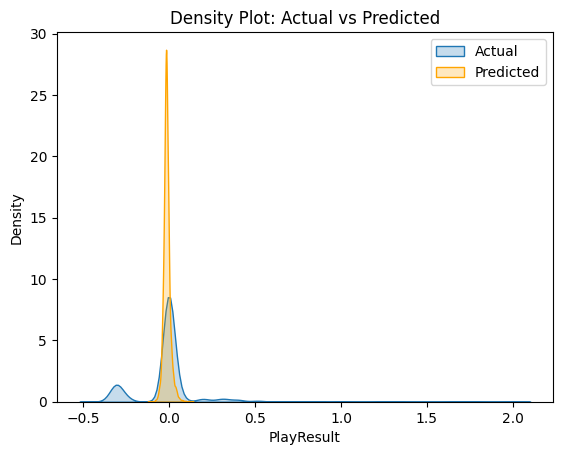

In [121]:
sns.kdeplot(y_test, label='Actual', fill=True)
sns.kdeplot(y_pred, label='Predicted', fill=True, color='orange')
plt.xlabel('PlayResult')
plt.ylabel('Density')
plt.title('Density Plot: Actual vs Predicted')
plt.legend()
plt.show()

In [85]:
y.mean()

np.float64(-0.015879910829035535)

In [15]:
y.median()

np.float64(-0.33)

In [ ]:
import numpy as np
import pandas as pd

def predict_stuff_plus(event):
    # Define the full set of features used in training (12 features, based on error expecting 12)
    required_features = ['RelSpeed', 'SpinRate', 'RelHeight', 'RelSide', 'Extension', 
                        'InducedVertBreak', 'HorzBreak', 'VertApprAngle', 'ZoneSpeed', 
                        'ff_diff', 'ivb_diff', 'hb_diff']
    
    # Check if all required features are present; fill missing with 0 for fastballs
    input_data = {}
    for f in required_features:
        if f in event and not pd.isna(event[f]):
            input_data[f] = event[f]
        else:
            # For fastballs, set diff features to 0 if missing
            if event['TaggedPitchType'] == 'Fastball' and f in ['ff_diff', 'ivb_diff', 'hb_diff']:
                input_data[f] = 0
            else:
                return np.nan  # Missing critical feature
    
    # Convert to DataFrame for pipeline compatibility
    input_df = pd.DataFrame([input_data], columns=required_features)
    
    # Predict using the trained model (pipeline handles scaling)
    pred = final_model.predict(input_df)[0]
    
    # Apply inverse sigmoid transformation to compress to (0, 1), where higher pred -> lower Stuff+
    k = 10  # Steepness parameter (adjusted for xRV range)
    xrv_mean = y.mean() if hasattr(y, 'mean') else 0.28  # Fallback to approximate xRV mean
    sigmoid = 1 / (1 + np.exp(k * (pred - xrv_mean)))  # Note: Removed negative sign to invert
    
    # Scale to 50-150 (lower pred -> higher Stuff+, higher pred -> lower Stuff+)
    scaled_pred = 50 + (150 - 50) * sigmoid
    
    return scaled_pred

In [129]:
import numpy as np
import pandas as pd

# Define the predict_stuff_plus function with dummy variable handling
def predict_stuff_plus(event):
    # Define the full set of features used in training (12 features + pitch type dummies)
    base_features = ['RelSpeed', 'SpinRate', 'RelHeight', 'RelSide', 'Extension', 
                     'InducedVertBreak', 'HorzBreak', 'VertApprAngle', 'ZoneSpeed', 
                     'ff_diff', 'ivb_diff', 'hb_diff']
    
    # Check if all base features are present; fill missing with 0 for fastballs
    input_data = {}
    for f in base_features:
        if f in event and not pd.isna(event[f]):
            input_data[f] = event[f]
        else:
            # For fastballs, set diff features to 0 if missing
            if event['TaggedPitchType'] == 'Fastball' and f in ['ff_diff', 'ivb_diff', 'hb_diff']:
                input_data[f] = 0
            else:
                return np.nan  # Missing critical feature
    
    # Create dummy variables for TaggedPitchType
    if 'TaggedPitchType' in event and not pd.isna(event['TaggedPitchType']):
        dummies = pd.get_dummies(pd.Series(event['TaggedPitchType']), prefix='PitchType', dtype=float)
        input_data.update(dummies.iloc[0].to_dict())
    else:
        return np.nan  # Missing TaggedPitchType
    
    # Convert to DataFrame and align with training columns
    input_df = pd.DataFrame([input_data])
    
    # Get the feature names from the trained model (assuming pipeline with RobustScaler and XGBRegressor)
    feature_names = final_model.named_steps['xgbregressor'].get_booster().feature_names
    if feature_names is None:
        # Fallback: Use the columns from X_train if available (you may need to pass X_train columns)
        feature_names = X_train.columns  # Ensure X_train is defined in the scope
    
    # Reindex input_df to match the expected feature order and fill missing columns with 0
    input_df = input_df.reindex(columns=feature_names, fill_value=0)
    
    # Predict using the trained model
    pred = final_model.predict(input_df)[0]
    
    # Apply inverse sigmoid transformation to compress to (0, 1), where higher pred -> lower Stuff+
    k = 50  # Steepness parameter (adjusted for xRV range)
    xrv_mean = y.mean() if hasattr(y, 'mean') else 0.28  # Fallback to approximate xRV mean
    sigmoid = 1 / (1 + np.exp(k * (pred - xrv_mean)))  # Inverted logic
    
    # Scale to 50-150 (lower pred -> higher Stuff+, higher pred -> lower Stuff+)
    scaled_pred = 50 + (150 - 50) * sigmoid
    
    return scaled_pred

# Use the entire dataset
df_all = df.copy()

## Stuff+ Calculation ##
# Calculate the mean and standard deviation of delta_run_exp_mean for the entire dataset
target_mean = df_all['delta_run_exp_mean'].mean()
target_std = df_all['delta_run_exp_mean'].std()

# Standardize the delta_run_exp_mean column to create a z-score
df_all['target_zscore'] = (df_all['delta_run_exp_mean'] - target_mean) / target_std

# Convert the z-score to Stuff+ (100 - zscore * 10)
df_all['stuff_plus'] = 100 - (df_all['target_zscore'] * 10)

# Aggregate Stuff+ by pitcher_id
df_agg = df_all.groupby(['Pitcher']).agg(
    count=('stuff_plus', 'size'),
    mean_stuff_plus=('stuff_plus', 'mean')
).reset_index()

# Apply predict_stuff_plus to get model-based Stuff+
df_all['predicted_stuff_plus'] = df_all.apply(predict_stuff_plus, axis=1)

# Display results
print("Aggregated Stuff+ by Pitcher:")
print(df_agg)

print("\nSample of Data with Predicted Stuff+:")
print(df_all[['Pitcher', 'delta_run_exp_mean', 'stuff_plus', 'predicted_stuff_plus']].head())


Aggregated Stuff+ by Pitcher:
            Pitcher  count  mean_stuff_plus
0       Adan Nieves     99       100.335945
1       Aiden Cline     24       103.506262
2      Aj Dallmayer     45       101.089081
3      Alec Bergman     52       100.332677
4        Alex Logan     49        97.286333
..              ...    ...              ...
146   Zach Leuschen     58        99.087008
147    Zach Neville     23        99.644356
148  Zach O'Donnell     22        96.137916
149  Zach O'donnell    147       100.138079
150  Zach Zychowski      5       106.232525

[151 rows x 3 columns]

Sample of Data with Predicted Stuff+:
       Pitcher  delta_run_exp_mean  stuff_plus  predicted_stuff_plus
0  Roy Rolston           -0.002789   99.258363            100.004784
1  Roy Rolston           -0.004735   99.369313             73.965366
2  Roy Rolston           -0.001602   99.190676                   NaN
3  Roy Rolston            0.000000   99.099355            116.734913
4  Roy Rolston           -0.001730

In [130]:
df_agg.to_csv('test.csv')

In [110]:

cornbelters_files = glob.glob("../CornBeltersData/*.csv")
kcl_files = glob.glob("../kclData/*.csv")


# Read and concatenate all CSVs into one DataFrame
cornbelters  = [pd.read_csv(f) for f in cornbelters_files]
kcl = [pd.read_csv(f) for f in kcl_files]
kcl_df = pd.concat(kcl, ignore_index=True)
cornbelters_df = pd.concat(cornbelters, ignore_index=True)

In [111]:
offspeed_pitches = ['Sinker','Curveball','Slider','Cutter','Cutter']

def calculate_ff_diff(event):
    """Calculate fastball speed difference with error handling"""
    if pd.notna(event['RelSpeed']) and pd.notna(event['TaggedPitchType']) and event['TaggedPitchType'] in offspeed_pitches:
        fastball_avg = kcl_df[(kcl_df['Pitcher'] == event['Pitcher']) & 
                         (kcl_df['TaggedPitchType'] == 'Fastball')]['RelSpeed'].mean()
        if pd.notna(fastball_avg):
            return fastball_avg - event['RelSpeed']
    return np.nan

def calculate_ivb_diff(event):
    """Calculate induced vertical break difference with error handling"""
    if pd.notna(event['InducedVertBreak']) and pd.notna(event['TaggedPitchType']) and event['TaggedPitchType'] in offspeed_pitches:
        fastball_avg = kcl_df[(kcl_df['Pitcher'] == event['Pitcher']) & 
                         (kcl_df['TaggedPitchType'] == 'Fastball')]['InducedVertBreak'].mean()
        if pd.notna(fastball_avg):
            return fastball_avg - event['InducedVertBreak']
    return np.nan

def calculate_hb_diff(event):
    """Calculate horizontal break difference with error handling"""
    if pd.notna(event['HorzBreak']) and pd.notna(event['TaggedPitchType']) and event['TaggedPitchType'] in offspeed_pitches:
        fastball_avg = kcl_df[(kcl_df['Pitcher'] == event['Pitcher']) & 
                         (kcl_df['TaggedPitchType'] == 'Fastball')]['HorzBreak'].mean()
        if pd.notna(fastball_avg):
            return fastball_avg - event['HorzBreak']
    return np.nan

In [117]:
kcl_df['ff_diff'] = kcl_df.apply(calculate_ff_diff, axis=1)
kcl_df['ivb_diff'] = kcl_df.apply(calculate_ivb_diff, axis=1)
kcl_df['hb_diff'] = kcl_df.apply(calculate_hb_diff, axis=1)
cornbelters_df['ff_diff'] = cornbelters_df.apply(calculate_ff_diff, axis=1)
cornbelters_df['ivb_diff'] = cornbelters_df.apply(calculate_ivb_diff, axis=1)
cornbelters_df['hb_diff'] = cornbelters_df.apply(calculate_hb_diff, axis=1)

In [121]:
kcl_df['Stuff+'] = kcl_df.apply(predict_stuff_plus,axis=1)
cornbelters_df['Stuff+'] = cornbelters_df.apply(predict_stuff_plus,axis=1)

In [122]:
pitcher_stuffplus = kcl_df.groupby('Pitcher')['Stuff+'].mean().reset_index()
pitcher_stuffplus.to_csv('stuff+.csv')
cornbelters_stuffplus = cornbelters_df.groupby('Pitcher')['Stuff+'].mean().reset_index()
cornbelters_stuffplus.to_csv('cb.csv')

In [123]:
import pickle

In [116]:
with open("stuff_plus_model.pkl", "wb") as f:
    pickle.dump(xgb_model, f)